## Demo walk along - with Jake Vanderplas (Ising Model)

In [1]:
### Def: Ising model, per wikipedia

# The Ising model (/ˈaɪsɪŋ/; German: [ˈiːzɪŋ]), 
# named after the physicist Ernst Ising, is a 
# mathematical model of ferromagnetism in 
# statistical mechanics. 

#https://en.wikipedia.org/wiki/Ising_model

In [2]:
### Def: Cython 

# Cython gives you the combined power of 
# Python and C

#http://cython.org

### Agenda:
* Code a simulated ising model
* Use Cython to speed the code up

### Part 1: Create image of pluses and minuses

In [3]:
### Import necessary libraries

import numpy as np
from PIL import Image
from ipywidgets import interact

In [4]:
### Create function to generate random 1s and -1s

# np.random.choice -> creates random values of -1 and 1 in our example
# np.random.choice (size) -> this is the output shape, so N rows by M columns

def random_spin_field(N, M):
    return np.random.choice([-1,1], size=(N,M))

In [5]:
### Generate a 20 x 20 grid of 1s and -1s

random_spin_field(10,10)

array([[-1, -1, -1,  1,  1, -1, -1,  1,  1, -1],
       [ 1,  1, -1,  1, -1,  1, -1,  1, -1, -1],
       [ 1, -1,  1,  1, -1,  1,  1,  1,  1,  1],
       [ 1, -1,  1,  1, -1, -1,  1,  1, -1, -1],
       [ 1,  1,  1, -1,  1,  1, -1,  1,  1, -1],
       [ 1, -1,  1,  1, -1,  1,  1, -1, -1,  1],
       [ 1,  1, -1, -1, -1, -1,  1,  1, -1,  1],
       [-1, -1, -1,  1, -1,  1, -1, -1,  1,  1],
       [-1,  1,  1, -1, -1, -1, -1, -1, -1,  1],
       [-1, -1, -1, -1, -1, -1, -1,  1,  1, -1]])

In [6]:
### Create function to display array field

# Image.fromarray() -> creates image from array
# np.unit8(field +1) * 0.5 * 255 -> converts 1s and -1s 
# unit8 -> unsigned integer data type and varies from 0 to 255

def display_spin_field(field):
    return Image.fromarray(np.uint8((field + 1) * 0.5 * 255))


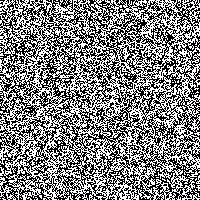

In [7]:
### Display the array field

display_spin_field(random_spin_field(200,200))

### Part 2: Create the ising model

In [8]:
### Create function to generate ising model

# This function allows us to update inplace
# beta -> refers to the temperature

def ising_step(field, beta=0.4):
    N, M = field.shape
    # Create offset to remove gradient look from left to right and top down
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _ising_update(field, n, m, beta)
    return field

# This function allows us to calculate the energies
# 
def _ising_update(field, n, m, beta):
    total = 0
    N, M = field.shape
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i % N,j % M]
    dE = 2 * field[n,m] * total
    if dE <=0:
        field[n,m] *= -1
    elif np.exp(-dE * beta) > np.random.rand():
        field[n,m] *= -1
            

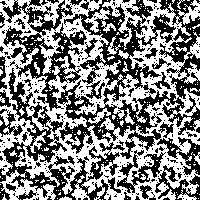

In [9]:
### Display the ising step

display_spin_field(ising_step(random_spin_field(200,200)))

### Part 3: Animate to display more than one image at a time

In [10]:
#### Using Ipywidgets - create javascript widgets

In [11]:
### Create function to display sequenced images

def display_ising_sequence(images):
    def _show(frame=(0, len(images)-1)):
        return display_spin_field(images[frame])
    return interact(_show)

In [12]:
### Create image animation

images = [random_spin_field(200,200)]
for i in range(50):
    images.append(ising_step(images[-1].copy()))
display_ising_sequence(images)

interactive(children=(IntSlider(value=25, description='frame', max=50), Output()), _dom_classes=('widget-inter…

<function __main__.display_ising_sequence.<locals>._show>

In [14]:
### Note -

# Had to use source code updates for my version of jupyter notebook

## Update via terminal
# pip install ipywidgets
# jupyter nbextension enable --py --sys-prefix widgetsnbextension  # can be skipped for notebook version 5.3 and above

# this allowed the widget to display
